## ASTR 597A Homework 3
Eric Bellm

Due Jan 24, 2023

Your name: David
    
Your collaborators: Tobin, Tom

In [1]:
# Generic python packages
import numpy as np
import matplotlib.pyplot as plt

# LSST Science Pipelines (Stack) packages
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
import lsst.sphgeom
import lsst.geom as geom

afwDisplay.setDefaultBackend('matplotlib')

# Set a standard figure size to use
plt.rcParams['figure.figsize'] = (8.0, 8.0)

In [2]:
butler = dafButler.Butler('dp02', collections='2.2i/runs/DP0.2')
registry = butler.registry

## Exercise 1: Ask the Butler

The 04b (Intermediate Butler Queries) tutorial notebooks may be helpful.

### Exercise 1a

How many DP0.2 tracts have r-band `'deepCoadd'`s?

#### Solution: there are 157 tracts with r-band deep Coadds

In [3]:
# for dt in sorted(registry.queryDatasetTypes()):
#     print(dt)

In [4]:
dt_deepCoadd = registry.getDatasetType('deepCoadd')
print(dt_deepCoadd)

DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF)


In [5]:
import pandas as pd

In [6]:
# create dataframe for all values satisfying band == 'r'
datasetType = 'deepCoadd'
dataId = {'band': 'r'}
datasetRefs = registry.queryDatasets(datasetType, dataId=dataId)

df = pd.DataFrame([ref.dataId for ref in datasetRefs])
df

,band,skymap,tract,patch
0,r,DC2,3085,17
1,r,DC2,3086,12
2,r,DC2,3084,10
3,r,DC2,3084,32
4,r,DC2,3084,12
...,...,...,...,...
7688,r,DC2,5064,33
7689,r,DC2,4849,43
7690,r,DC2,5062,48
7691,r,DC2,5062,13


In [7]:
# count the number of unique tracts
len(df['tract'].unique())

157

### Exercise 1b

Find the tract and patch corresponding to (ra, dec) 62.0, -37.0.  If there is more than one r-band `deepCoad` at that position, make a plot that explains why.

#### Solution: the given ra and dec are in both patch 3 and patch 10 of tract 3831. See the green x on the plotted images of both tracts

In [8]:
my_ra_deg = 62
my_dec_deg = -37
my_filter = 'r'

my_spherePoint = lsst.geom.SpherePoint(my_ra_deg*lsst.geom.degrees, my_dec_deg*lsst.geom.degrees)

skymap = butler.get('skyMap')
tract = skymap.findTract(my_spherePoint)
my_tract = tract.tract_id
my_patch = tract.findPatch(my_spherePoint).getSequentialIndex()
print('My tract and patch: ', my_tract, my_patch)

My tract and patch:  3831 10


In [9]:
level = 23  # the resolution of the HTM grid
pixelization = lsst.sphgeom.HtmPixelization(level)

ra, dec = 62, -37
htm_id = pixelization.index(
    lsst.sphgeom.UnitVector3d(
        lsst.sphgeom.LonLat.fromDegrees(ra, dec)
    )
)

In [10]:
circle = pixelization.triangle(htm_id).getBoundingCircle()
scale = circle.getOpeningAngle().asDegrees()*3600.
level = pixelization.getLevel()
print(f'HTM ID={htm_id} at level={level} is bounded by a circle of radius ~{scale:0.2f} arcsec.')

HTM ID=617345737139805 at level=23 is bounded by a circle of radius ~0.04 arcsec.


In [11]:
datasetRefs = registry.queryDatasets("deepCoadd", htm20=htm_id, dataId=dataId)

for i, ref in enumerate(datasetRefs):
    print(ref)
    if i > 6:
        print('...')
        break

print(f"Found {len(list(datasetRefs))} deepCoadd")

deepCoadd@{band: 'r', skymap: 'DC2', tract: 3831, patch: 3}, sc=ExposureF] (id=4b0c49ef-36ab-4377-b3a9-62cd8ca60e46)
deepCoadd@{band: 'r', skymap: 'DC2', tract: 3831, patch: 10}, sc=ExposureF] (id=76cc103b-03ce-4d32-9829-4ba650271878)
Found 2 deepCoadd


In [13]:
coadds = [butler.get(ref) for ref in datasetRefs]

In [14]:
coadd_wcs = coadds[0].wcs

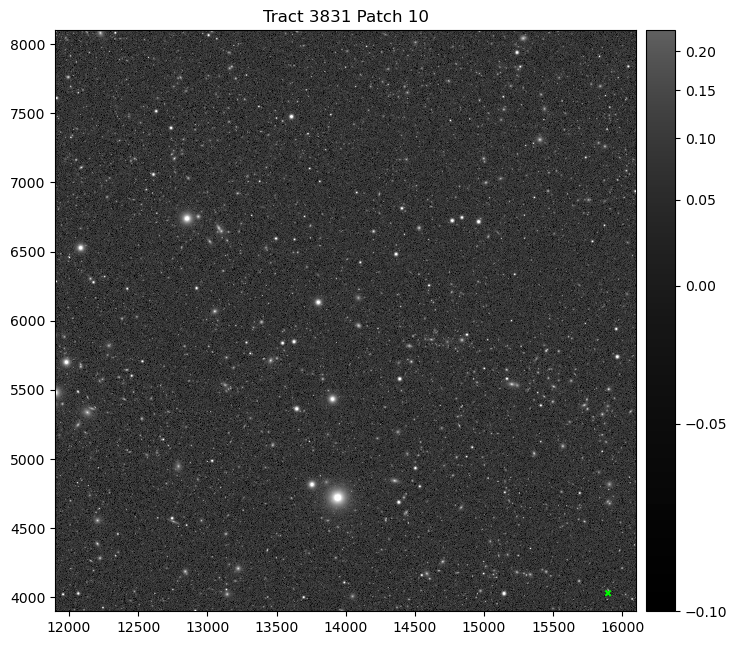

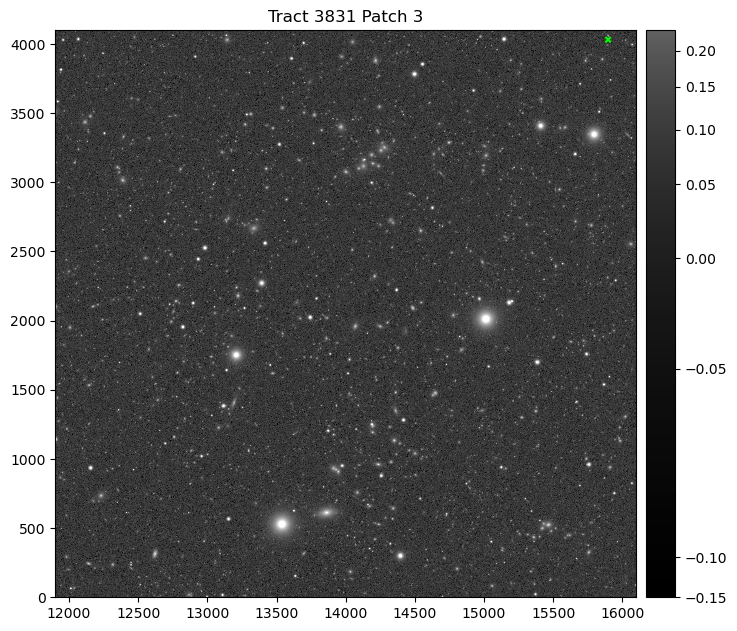

In [15]:
pt = coadd_wcs.skyToPixel(lsst.geom.SpherePoint(62*lsst.geom.degrees, -37*lsst.geom.degrees))
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(coadds[1].image)
display.dot('x', *pt, size=20)
plt.title('Tract 3831 Patch 10')
plt.show() 
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(coadds[0].image)
display.dot('x', *pt, size=20)
plt.title('Tract 3831 Patch 3')
plt.show()

### Exercise 1c

Using the (tract, patch) with the lowest patch number, plot histograms of the seeing values of the images that were coadded in the r-band `deepCoadd` and `goodSeeingCoadd` for that (tract, patch).  Tutorial notebook 09a (Custom Coadd)will give you some ideas on how to get the `coaddInputs`.  The `coaddInputs.ccds` table will be helpful.

For each input `calexp`, you will need to retrieve the PSF and then use `psf.computeShape(psf.getAveragePosition()).getDeterminantRadius()` to get the PSF width in sigma.  Convert these to FWHM in arcseconds for your plots.

#### Solution: see the histogram below

In [16]:
# Retrieve inputs

my_deepCoadd_inputs = coadds[0].getInfo().getCoaddInputs()

In [17]:
deep_inputs = my_deepCoadd_inputs.ccds.asAstropy().to_pandas()

In [18]:
# point to calculate psf from (copied from tutorial 5)
x_target, y_target = 1700, 2100
width, height = 400, 400
xmin, ymin = x_target-width//2, y_target-height//2
point = geom.Point2D(x_target, y_target)

In [19]:
from pathlib import Path
deep_path = Path('/home/ykwang1/WORK/astr597-survey-science/data/deepCoaddsInputs.csv')
good_path = Path('/home/ykwang1/WORK/astr597-survey-science/data/goodCoaddsInputs.csv')

In [20]:
deep_path.exists()

True

In [21]:
if not deep_path.exists():
    deep_fwhm = []
    for ii in deep_inputs.index:
        dataId = {'visit': deep_inputs.loc[ii, 'visit'], 'detector': deep_inputs.loc[ii, 'ccd']}
        calexp = butler.get('calexp', **dataId)

        psf = calexp.getPsf()
        sigma = psf.computeShape(point).getDeterminantRadius()
        pixelScale = calexp.getWcs().getPixelScale().asArcseconds()
        deep_fwhm.append(sigma*pixelScale*2.355)

    deep_fwhm = np.array(deep_fwhm)

    deep_inputs['fwhm'] = deep_fwhm
    deep_inputs.to_csv(deep_path.as_posix(), index=False)

else:
    deep_inputs = pd.read_csv(deep_path.as_posix())
    deep_fwhm = deep_inputs['fwhm'] 

In [22]:
good_inputs = registry.queryDatasets("goodSeeingCoadd.coaddInputs", dataId={'band': 'r', 'skymap': 'DC2', 'tract': 3831, 'patch': 3})
good_inputs = butler.get([x for x in good_inputs][0]).ccds.asAstropy().to_pandas()

In [23]:
if not good_path.exists():
    good_fwhm = []
    for ii in good_inputs.index:
        dataId = {'visit': good_inputs.loc[ii, 'visit'], 'detector': good_inputs.loc[ii, 'ccd']}
        calexp = butler.get('calexp', **dataId)

        psf = calexp.getPsf()
        sigma = psf.computeShape(point).getDeterminantRadius()
        pixelScale = calexp.getWcs().getPixelScale().asArcseconds()
        good_fwhm.append(sigma*pixelScale*2.355)

    good_fwhm = np.array(good_fwhm)

    good_inputs['fwhm'] = good_fwhm
    good_inputs.to_csv(good_path.as_posix(), index=False)
else:
    good_inputs = pd.read_csv(good_path.as_posix())
    good_fwhm = good_inputs['fwhm']

In [24]:
bins = np.linspace(deep_fwhm.min(), deep_fwhm.max(), 20)

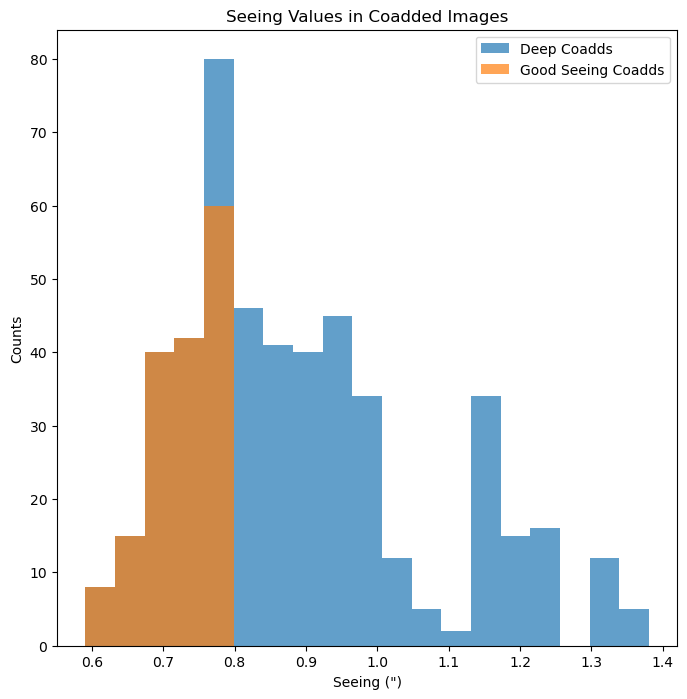

In [25]:
plt.hist(deep_fwhm, label='Deep Coadds', bins=bins, alpha=.7)
plt.hist(good_fwhm, label='Good Seeing Coadds', bins=bins, alpha=.7)
plt.title('Seeing Values in Coadded Images')
plt.legend()
plt.xlabel('Seeing (")')
plt.ylabel('Counts')
plt.show()

## Exercise 2: DIY Good-seeing Coadd

Complete the `09a_Custom_Coadd` tutorial notebook, but rather than coadding all of the visits within a temporal window, instead coadd the three first three visits that have seeing values in the range included in the `goodSeeingCoadd` inputs.  Display the result and compare to the standard `deepCoadd` and `goodSeeingCoadd`.

Coadded template images are a necessary input to alert production.  What are the implications of this exercise for alert generation early in the LSST survey?  How many images were taken before three images had good enough seeing?  How long did the survey run before the images were acquired?

#### Solution: it took 4 total visits over 27 days to obtain 3 visits satisfying the good seeing requirement (seeing < ~.79") for the given tract, patch, and band.
Since we need templates to do alert production, the difference image analysis cannot kick in until these templates are made from coadds, and based on this one data point, we may need a least a month to create these templates. See end of notebook for the coadd of 3 good seeing visits.

Since each individual visit has a limiting magnitude of about 24.5 mag, The fact that the initial coadd is not as sensitive as the final coadds is probably okay for alert production.


In [26]:
%%time

# get tract and patch for thise particular sky coord and filter
my_ra_deg = 55.745834
my_dec_deg = -32.269167
my_filter = 'i'

my_spherePoint = lsst.geom.SpherePoint(my_ra_deg*lsst.geom.degrees, my_dec_deg*lsst.geom.degrees)

skymap = butler.get('skyMap')
tract = skymap.findTract(my_spherePoint)
my_tract = tract.tract_id
my_patch = tract.findPatch(my_spherePoint).getSequentialIndex()
print('My tract and patch: ', my_tract, my_patch)

my_dataId = {'band': my_filter, 'tract': my_tract, 'patch': my_patch}
my_deepCoadd = butler.get('deepCoadd', dataId=my_dataId)

del my_ra_deg, my_dec_deg, my_filter, my_spherePoint, skymap, tract

My tract and patch:  4431 17
CPU times: user 2.84 s, sys: 902 ms, total: 3.74 s
Wall time: 4.29 s


In [27]:
# use the butler to get visit table and look up the MJDs of the visits of the deep coadd inputs and good seeing coadd inputs
visitTableRef = list(butler.registry.queryDatasets('visitTable'))
visitTable = butler.get(visitTableRef[0])

my_coadd_inputs = my_deepCoadd.getInfo().getCoaddInputs().visits.asAstropy().to_pandas()
good_coadd_inputs = butler.get('goodSeeingCoadd', dataId=my_dataId)
good_coadd_inputs = good_coadd_inputs.getInfo().getCoaddInputs().visits.asAstropy().to_pandas()

my_coadd_inputs.set_index('id', inplace=True)
good_coadd_inputs.set_index('id', inplace=True)

my_coadd_inputs['mjd'] = visitTable.loc[my_coadd_inputs.index]['expMidptMJD']
good_coadd_inputs['mjd'] = visitTable.loc[good_coadd_inputs.index]['expMidptMJD']



In [28]:
# get the first 3 temporal inputs to the good seeing coadd and find the total visits before and including these 3 visits
first3 = good_coadd_inputs.sort_values('mjd').iloc[:3]

time_needed = my_coadd_inputs.query(f"mjd <= {first3.iloc[-1]['mjd']}")
time_needed['mjd'].max() - time_needed['mjd'].min()

26.99831799884123

### Create a coadd out of the 3 good seeing visits

In [29]:
my_visits_tupleString = "("+",".join(first3.index.astype(str))+")"
print(my_visits_tupleString)

(174602,177422,192350)


In [30]:
import getpass


In [31]:
my_username = getpass.getuser()
print(my_username)

ykwang1


In [32]:
my_collection_identifier = 'custom_coadd_window1_test1'
print(my_collection_identifier)

custom_coadd_window1_test1


In [33]:
my_outputCollection = 'u/'+my_username+'/'+my_collection_identifier
print('Name of new butler collection for my output: ', my_outputCollection)

Name of new butler collection for my output:  u/ykwang1/custom_coadd_window1_test1


In [34]:
for c in sorted(butler.registry.queryCollections()):
    if c.find(my_outputCollection) > -1:
        print(c)

u/ykwang1/custom_coadd_window1_test1
u/ykwang1/custom_coadd_window1_test1/20230120T000002Z
u/ykwang1/custom_coadd_window1_test1/20230120T201009Z
u/ykwang1/custom_coadd_window1_test1/20230120T223411Z
u/ykwang1/custom_coadd_window1_test1/20230120T224308Z


In [35]:
from lsst.ctrl.mpexec import SimplePipelineExecutor


In [36]:
simpleButler = SimplePipelineExecutor.prep_butler('dp02', inputs=['2.2i/runs/DP0.2'], output=my_outputCollection)

In [37]:
my_outputCollection

'u/ykwang1/custom_coadd_window1_test1'

In [38]:
simpleButler.registry.getCollectionChain(my_outputCollection)


CollectionSearch(('u/ykwang1/custom_coadd_window1_test1/20230124T000638Z', '2.2i/runs/DP0.2'))

In [39]:
yaml_file = '$DRP_PIPE_DIR/pipelines/LSSTCam-imSim/DRP-DP0.2.yaml'
steps = 'makeWarp,assembleCoadd'
my_uri = yaml_file + '#' + steps
print(my_uri)

$DRP_PIPE_DIR/pipelines/LSSTCam-imSim/DRP-DP0.2.yaml#makeWarp,assembleCoadd


In [40]:
from lsst.pipe.base import Pipeline, Instrument

In [41]:
assembleCoaddPipeline = Pipeline.from_uri(my_uri)

In [42]:
assembleCoaddPipeline.addConfigOverride('makeWarp', 'doApplyFinalizedPsf', False)

In [43]:
queryString = f"tract = {my_tract} AND patch = {my_patch} AND " + \
              f"visit in {my_visits_tupleString} AND skymap = 'DC2'"

print(queryString)

tract = 4431 AND patch = 17 AND visit in (174602,177422,192350) AND skymap = 'DC2'


In [44]:
%%time
spe = SimplePipelineExecutor.from_pipeline(assembleCoaddPipeline, where=queryString, butler=simpleButler)

CPU times: user 1.18 s, sys: 99.7 ms, total: 1.28 s
Wall time: 17min 56s


In [45]:
%%time
quanta = spe.run()

CPU times: user 5min 10s, sys: 14.7 s, total: 5min 25s
Wall time: 5min 49s


In [46]:
for q, quantum in enumerate(quanta):
    print(q, quantum.taskName)

0 lsst.pipe.tasks.makeWarp.MakeWarpTask
1 lsst.pipe.tasks.makeWarp.MakeWarpTask
2 lsst.pipe.tasks.makeWarp.MakeWarpTask
3 lsst.pipe.tasks.assembleCoadd.CompareWarpAssembleCoaddTask


In [47]:
coadd_index = 3

In [48]:
my_new_deepCoadd = simpleButler.get(quanta[coadd_index].outputs['deepCoadd'][0])

(11899.5, 16099.5, 7899.5, 12099.5)

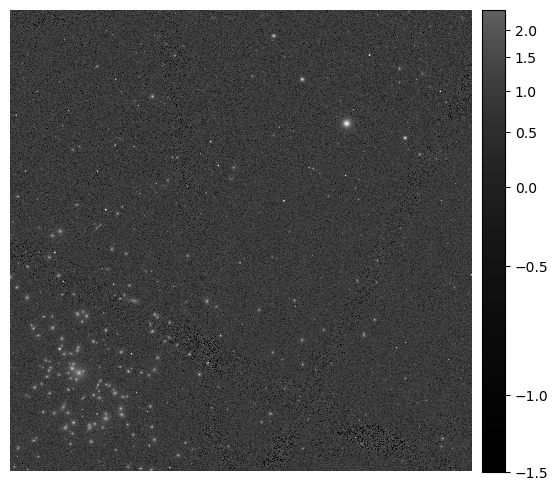

In [49]:
fig = plt.figure(figsize=(10, 6))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_new_deepCoadd.image)
plt.gca().axis('off')

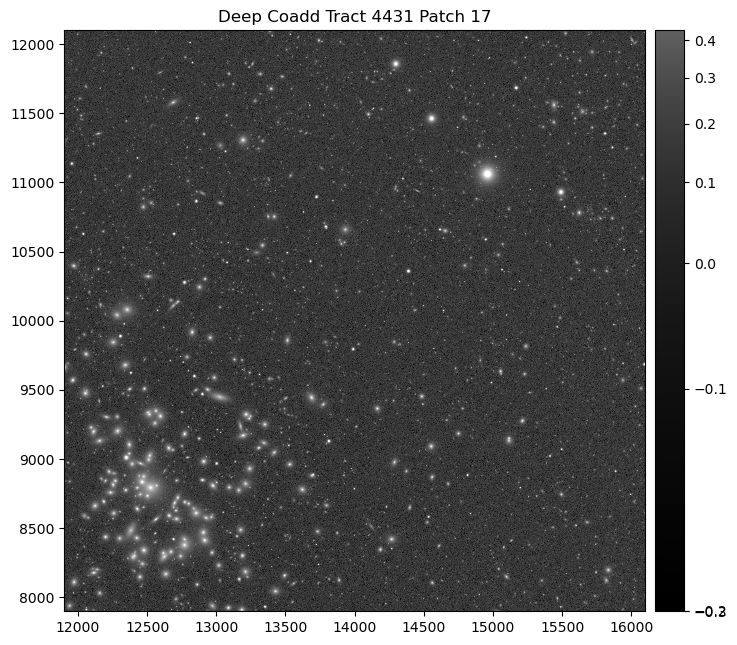

In [50]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(my_deepCoadd.image)
plt.title('Deep Coadd Tract 4431 Patch 17')
plt.show() 


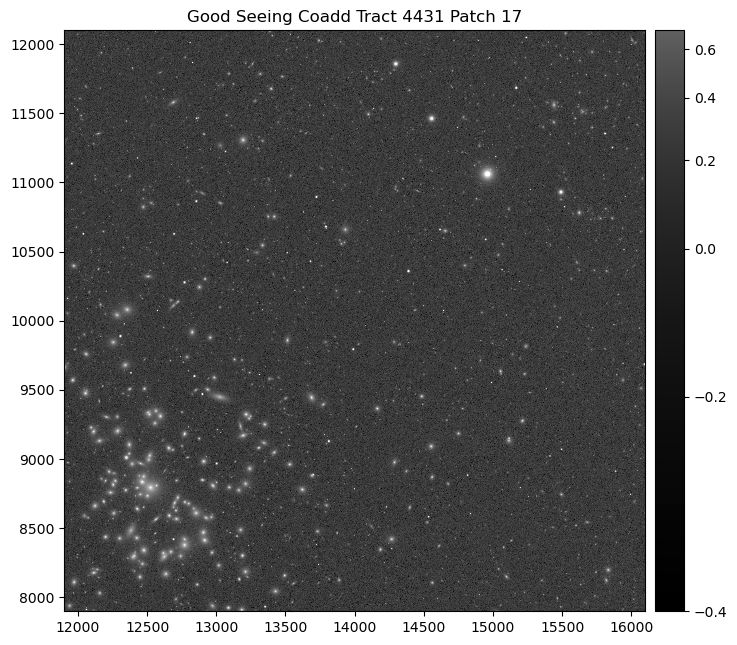

In [51]:
my_goodCoadd = butler.get('goodSeeingCoadd', dataId=my_dataId)
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(my_goodCoadd.image)
plt.title('Good Seeing Coadd Tract 4431 Patch 17')
plt.show() 

Both the deep coadd and good seeing coadd show more sources and are deeper than the addition of the first 3 good seeing visits. We can see this from both the displayed images, and the scales to thge right of the images. This isn't suprising since the SNR scales with the square of the cumulative exposure time.